<a href="https://colab.research.google.com/github/perses08/Siamese_learn/blob/main/CIFAR_10_siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import cifar100
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

train_images = train_images.astype('float32')/255.
test_images = test_images.astype('float32')/255.

169009152/169001437 [==============================] - 4s 0us/step


In [ ]:
train_images.shape

(50000, 32, 32, 3)

In [ ]:
def create_pairs(x, digit_indices):
    
    pairs = []
    labels = []
    
    n = min([len(digit_indices[d]) for d in range(30)]) - 1
    
    for d in range(30):
        
        for i in range(n):
            
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(30)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

In [ ]:
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

In [ ]:
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

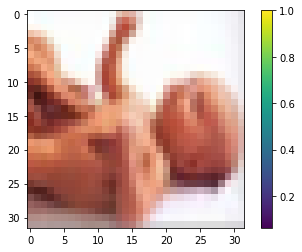

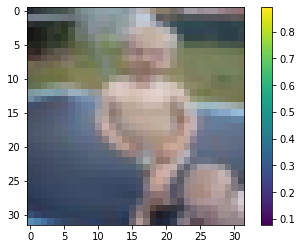

1.0


In [ ]:
this_pair = 400

show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

print(tr_y[this_pair])

In [ ]:
def initialize_base_network():
  
  input = Input(shape=(32,32,3),name="Base_Input")

  flatten_layer = Flatten(name='FL')(input)

  dense1 = Dense(256, activation='relu',name='D1')(flatten_layer)

  drop1 = Dropout(0.3,name='DO1')(dense1)

  dense2 = Dense(128, activation='relu',name = 'D2')(drop1)

  drop2 = Dropout(0.2,name = 'DO2')(dense2)

  dense3 = Dense(128, activation='relu',name='D3')(drop2)

  return Model(inputs= input, outputs = dense3)

In [ ]:
def euclidean_distance(vects):
    
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    
    shape1, shape2 = shapes
    
    return (shape1[0], 1)

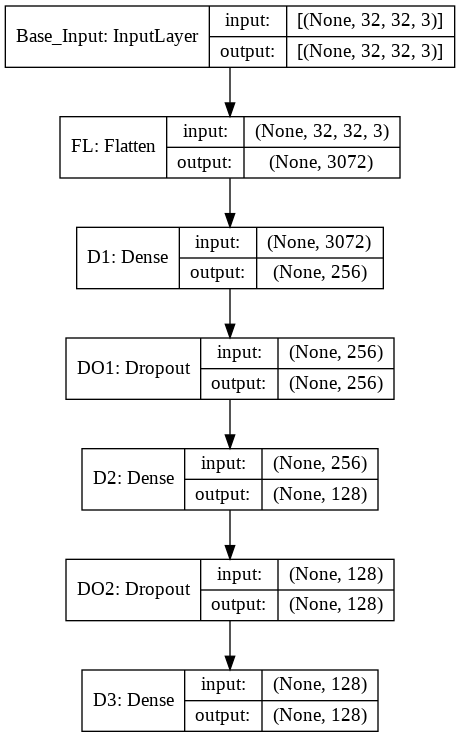

In [ ]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

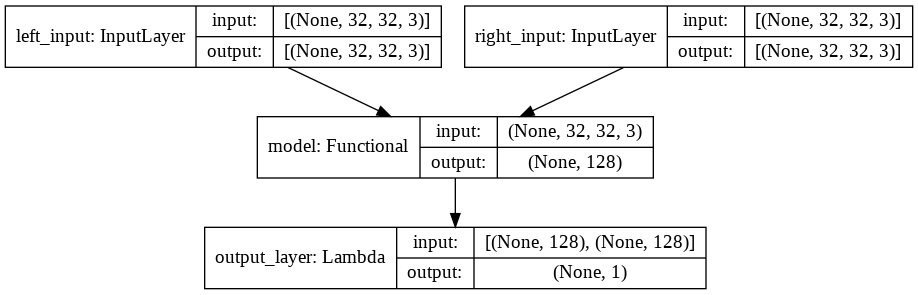

In [ ]:
input_a = Input(shape=(32,32,3), name="left_input")
vect_output_a = base_network(input_a)

input_b = Input(shape=(32,32,3), name="right_input")
vect_output_b = base_network(input_b)
 
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

model = Model([input_a, input_b], output)

plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [40]:
def contrastive_loss_with_margin(margin):
  '''Contrastive loss from Hadsell-et-al.'06 http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf'''
  def contrastive_loss(y_true, y_pred):
    
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  
  return contrastive_loss

In [41]:
def asa(m):
  def sas(a,b):
    return m*(a+b)

  def sss(c,d):
    return (c*d)
    
  return sas,sss

asd1,asd2 = asa(2)
print(asd1(1,2))
print(asd2(2,2))

6
4


In [42]:
rms = RMSprop()

model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

history = model.fit([tr_pairs[:,0],tr_pairs[:,1]],
                    tr_y, epochs=20,
                    batch_size=128, 
                    validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
234/234 [==============================] - 9s 34ms/step - loss: 2.8676 - val_loss: 0.3793
Epoch 2/20
234/234 [==============================] - 7s 30ms/step - loss: 0.2934 - val_loss: 0.3439
Epoch 3/20
234/234 [==============================] - 7s 31ms/step - loss: 0.2686 - val_loss: 0.3404
Epoch 4/20
234/234 [==============================] - 7s 30ms/step - loss: 0.2604 - val_loss: 0.3069
Epoch 5/20
234/234 [==============================] - 7s 30ms/step - loss: 0.2577 - val_loss: 0.3141
Epoch 6/20
234/234 [==============================] - 7s 30ms/step - loss: 0.2546 - val_loss: 0.3642
Epoch 7/20
234/234 [==============================] - 7s 31ms/step - loss: 0.2541 - val_loss: 0.4453
Epoch 8/20
234/234 [==============================] - 7s 30ms/step - loss: 0.2550 - val_loss: 0.4872
Epoch 9/20
234/234 [==============================] - 7s 30ms/step - loss: 0.2535 - val_loss: 0.3803
Epoch 10/20
234/234 [==============================] - 7s 30ms/step - loss: 0.2538 - val_lo

In [43]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

In [44]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])

train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])

test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

186/186 [==============================] - 1s 4ms/step - loss: 0.3465
Loss = 0.34649384021759033, Train Accuracy = 0.4935537742150969 Test Accuracy = 0.4952861952861953
